### Zernike Holography

TODO



#### Initialization

To start, we initialize our system:

In [2]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

In [3]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the Simple Holography section.
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1600, 1200), pitch_um=(8,8))
slm.set_source_analytic(sim=True)               # Program the virtual source.
slm.set_source_analytic()                       # Don't bother with wavefront calibration, instead just set it to the same source.

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [ ]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", fliplr=True)
fs = FourierSLM(cam, slm)

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


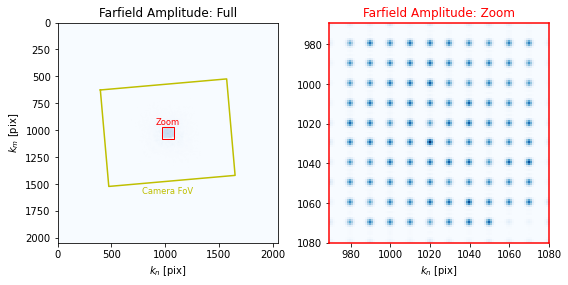

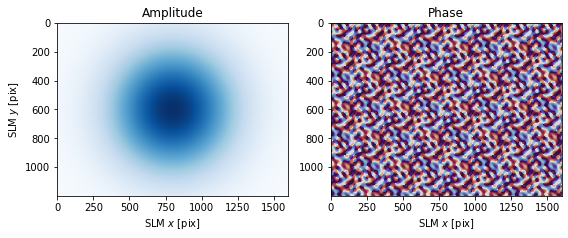

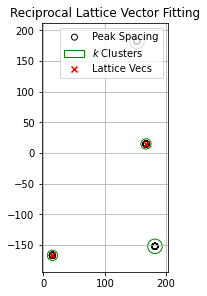

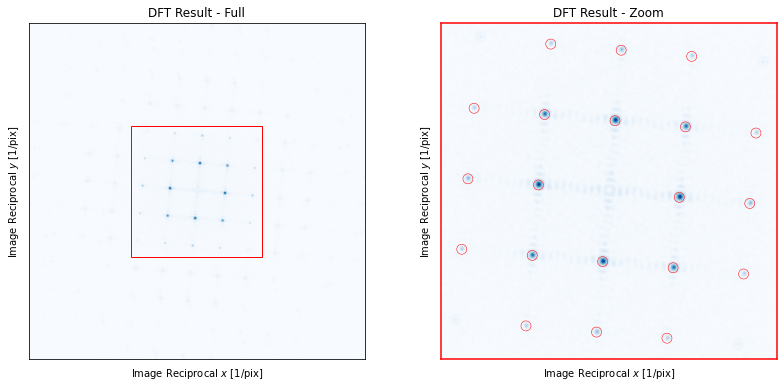

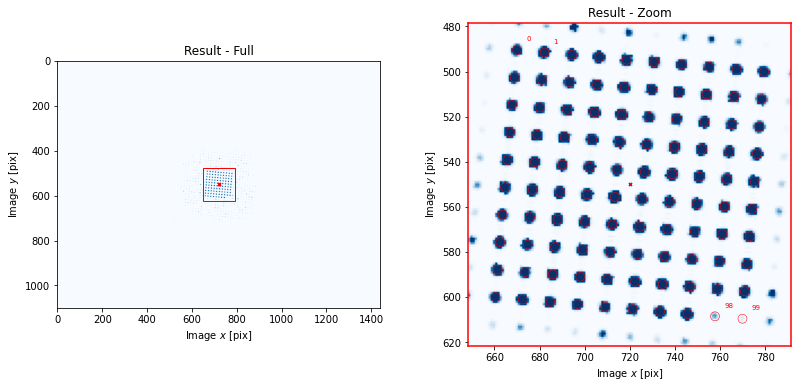

{'M': array([[19924.82375058, -1746.18308611],
        [ 1749.35577114, 19922.490231  ]]),
 'b': array([[719.99812214],
        [549.9999364 ]]),
 'a': array([[0.],
        [0.]]),
 '__version__': '0.0.2',
 '__time__': '2024-07-23 11:06:34.746873',
 '__timestamp__': 1721747194.746873,
 '__meta__': {'camera': 'camera', 'slm': 'SLM'}}

In [4]:
fs.fourier_calibrate(plot=True)

#### Zernike Indexing

TODO

In [70]:
from slmsuite.holography.toolbox.phase import zernike_convert_index

ansi = np.arange(10)
radial = zernike_convert_index(ansi, from_index="ansi", to_index="radial")
print(radial)

[[ 0  0]
 [ 1 -1]
 [ 1  1]
 [ 2 -2]
 [ 2  0]
 [ 2  2]
 [ 3 -3]
 [ 3 -1]
 [ 3  1]
 [ 3  3]]


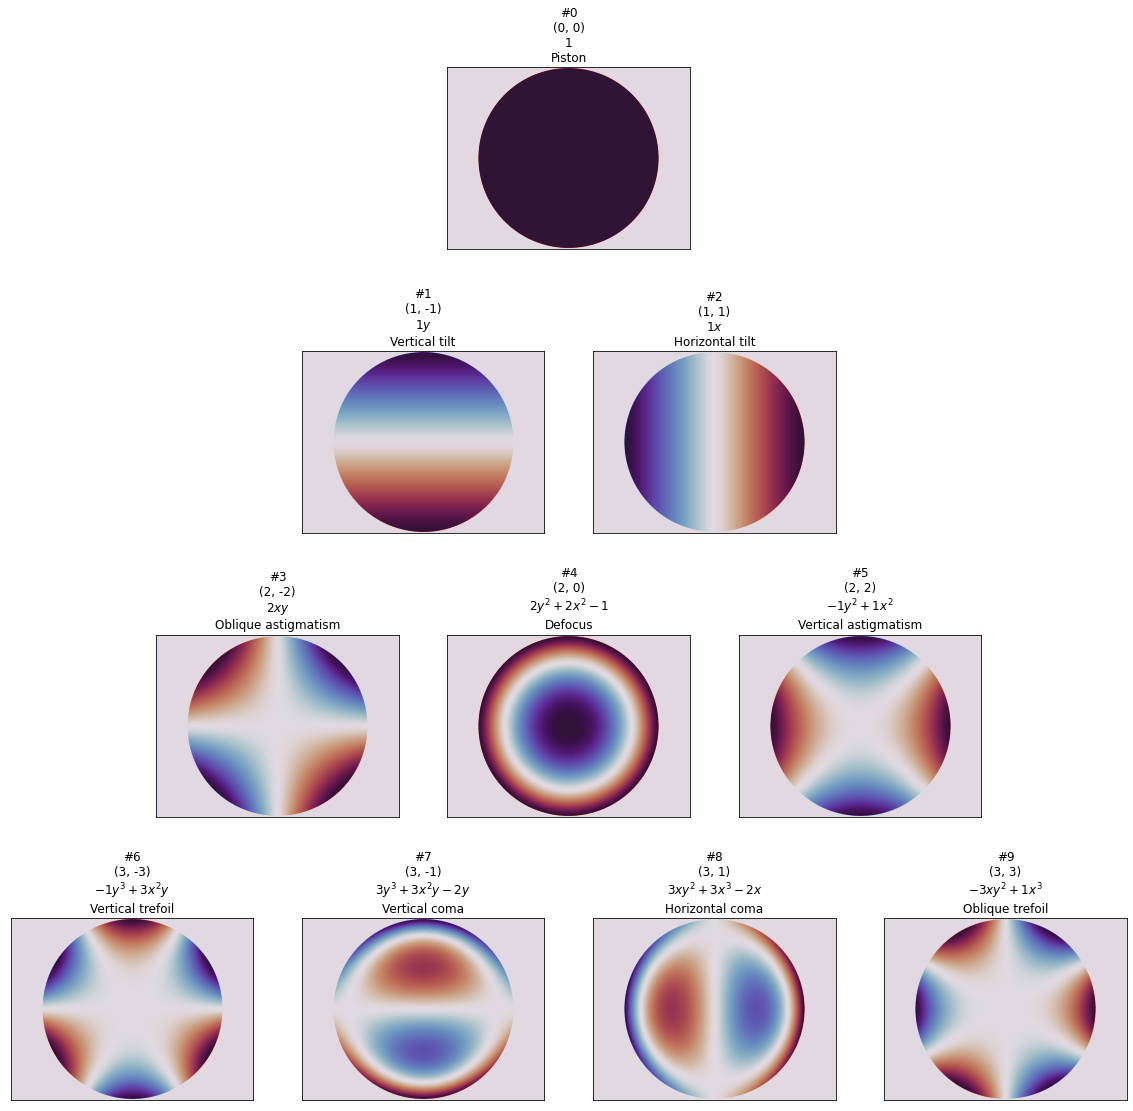

In [6]:
from slmsuite.holography.toolbox.phase import zernike_pyramid_plot

plt.figure(figsize=(20,20))
zernike_pyramid_plot(slm, order=3)

We also support derivates (computed analyticaly via the power rule before rendering, for
speed).

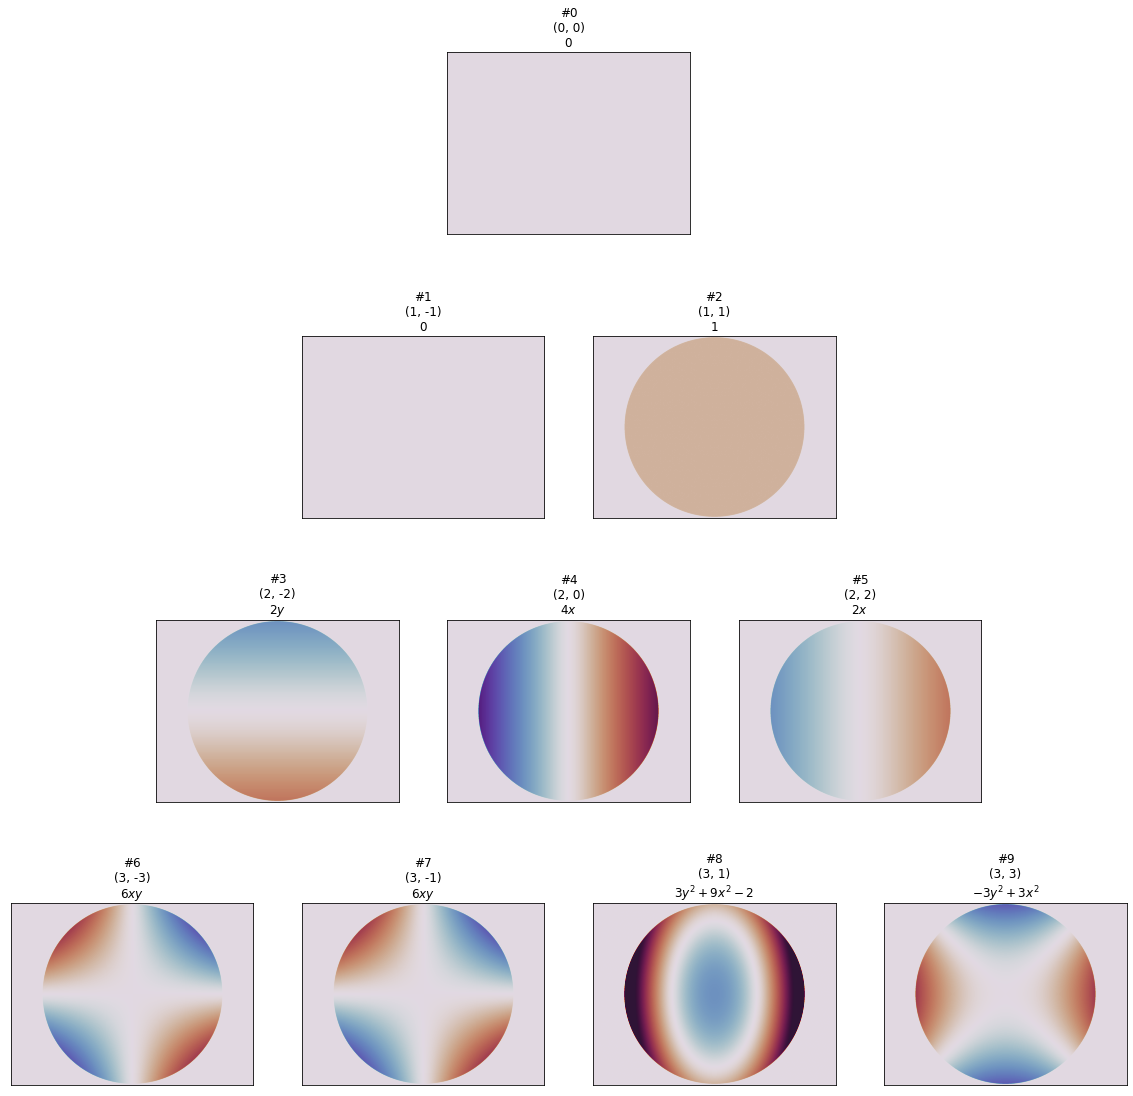

In [69]:
plt.figure(figsize=(20,20))
zernike_pyramid_plot(slm, order=3, derivative=(1, 0), scale=5)    # Adjust the scale because the derivative exceeds [-1, 1]

The core function `zernike_sum` supports generating stacks of Zernike polynomials, and
derivatives are applied to each.

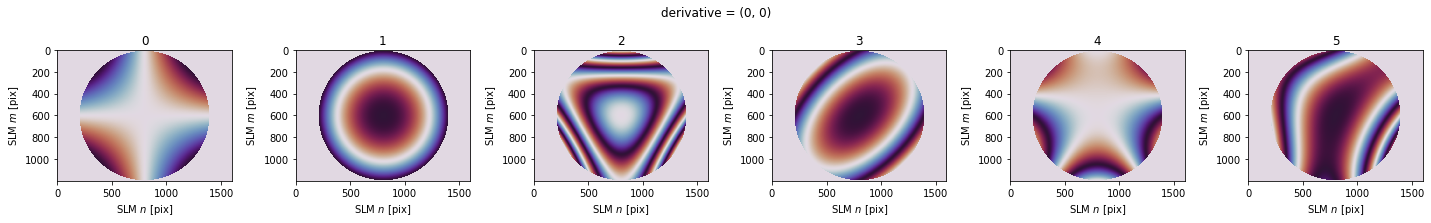

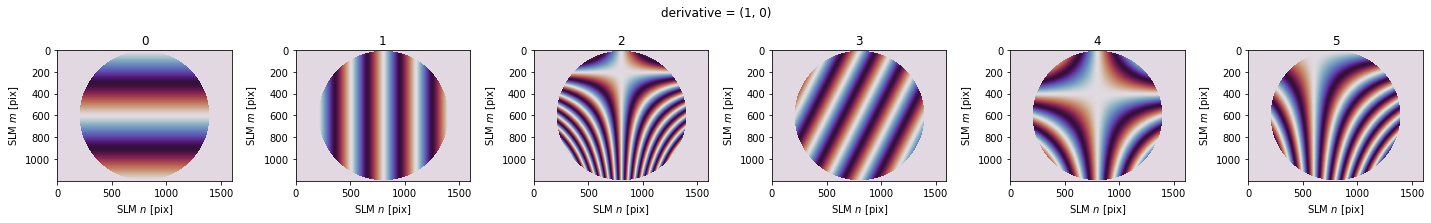

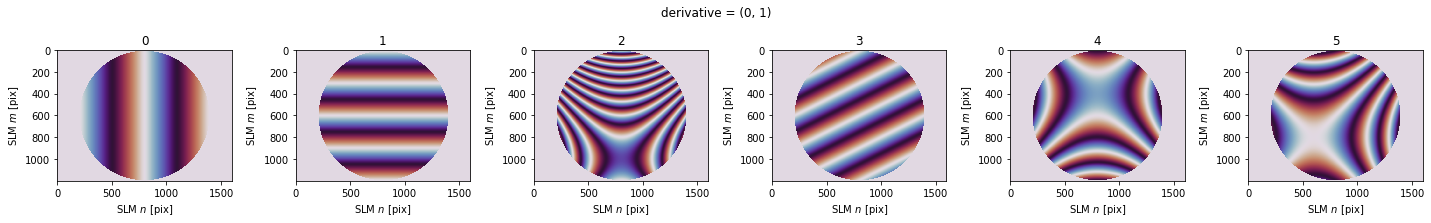

In [68]:
for derivative in [(0,0), (1,0), (0,1)]:
    images = np.pi * zernike_sum(
        slm,
        indices=[3,4,5,6],
        weights=[
            [1,0,0,1,0,1],      # I=1
            [0,1,2,1,0,1],      # I=2
            [0,0,0,0,1,1],      # I=3
            [0,0,2,0,1,1],      # I=4
        ],
        derivative=derivative
    )

    fig, axs = plt.subplots(1, 6, figsize=(20,3))

    for i, image in enumerate(images):
        plt.sca(axs[i])
        slm.plot(image, title=str(i), cbar=False)

    plt.suptitle(f"derivative = {derivative}")
    plt.tight_layout()
    plt.show()

#### 3D "Compressed Spot" Holography

TODO

In [14]:
from slmsuite.holography.toolbox import convert_vector, print_blaze_conversions

In [67]:
N = 100
x = np.arange(N) / 20

zeroth_order_ij = convert_vector((0,0), from_units="norm", to_units="ij", hardware=fs)

vectors_ij = np.vstack((
    25 * (x + 1) * np.cos(2 * np.pi * x) + zeroth_order_ij[0],
    25 * (x + 1) * np.sin(2 * np.pi * x) + zeroth_order_ij[1],
    200 * np.cos(1.5 * np.pi * x)
))

Under the hood, slmsuite is doing all the conversions.

In [44]:
print_blaze_conversions(
    vectors_ij[:, 0],       # Print the first vector.
    from_units="ij",
    hardware=fs,
    shape=(2048, 2048)
)

'rad' : (0.0012451344659744647, -0.00010933287649467178, 1.2499787441600336e-07)
'mrad' : (1.2451344659744648, -0.10933287649467179, 1.2499787441600336e-07)
'deg' : (0.07134094982661243, -0.006264312385169775, 1.2499787441600336e-07)
'norm' : (0.0012451344659744647, -0.00010933287649467178, 1.2499787441600336e-07)
'kxy' : (0.0012451344659744647, -0.00010933287649467178, 1.2499787441600336e-07)
'knm' : (1044.4002830905256, 1022.2086901515113, 1.2499787441600336e-07)
'freq' : (0.009961075727795718, -0.0008746630119573742, 1.2499787441600336e-07)
'lpmm' : (1.2451344659744648, -0.10933287649467179, 1.2499787441600336e-07)
'zernike' : (37.10693741194186, -3.25828921776755, 4.417133061168048)
'ij' : (744.9981221408813, 549.9999363995045, 200.0)
'm' : (0.002979992488563525, 0.002199999745598018, 0.0008)
'cm' : (0.2979992488563525, 0.21999997455980178, 0.08)
'mm' : (2.979992488563525, 2.199999745598018, 0.8)
'um' : (2979.992488563525, 2199.999745598018, 800.0)
'nm' : (2979992.488563525, 219999

Make the hologram.

In [64]:
from slmsuite.holography.algorithms import CompressedSpotHologram

hologram = CompressedSpotHologram(
    spot_vectors=vectors_ij,
    basis="ij",                 # For 3D spots, the basis defaults to Zernike terms [2,1,4] = [x,y,z].
    cameraslm=fs
)
hologram.optimize()

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Let's take a look at what we made:

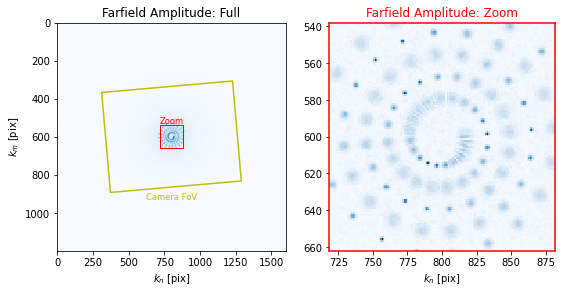

In [65]:
hologram.plot_farfield(limit_padding=-.45);

What's happening internally: basis of Zernike polynomials.

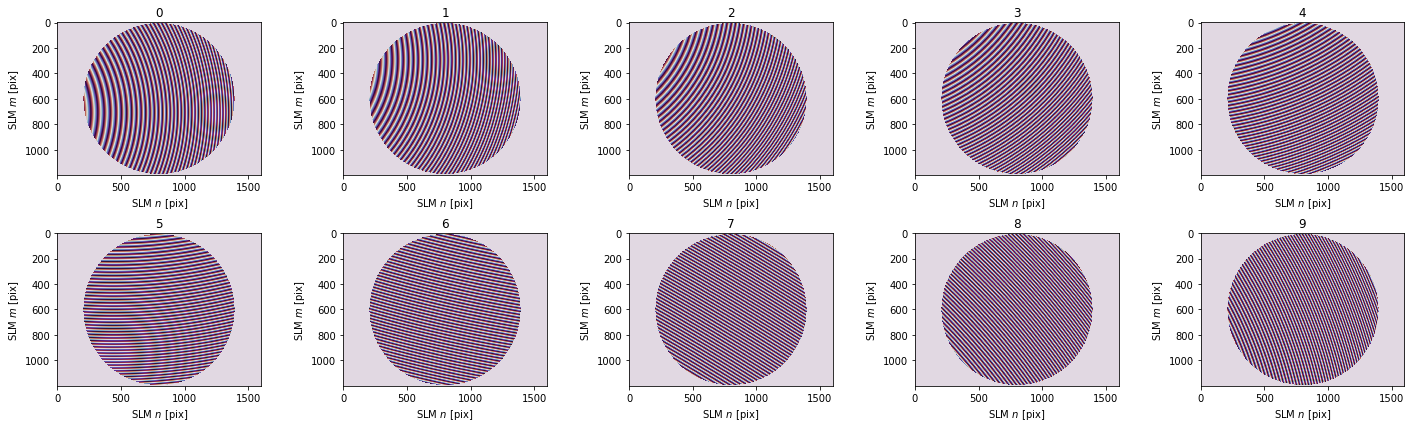

In [66]:
# Get the coordinates in "Zernike space" using the [2,1,4] = [x,y,z] terms.
vectors_zernike = convert_vector(
    vectors_ij,
    from_units="ij",
    to_units="zernike",
    hardware=fs
)

# Plot only the first 10.
images = np.pi * zernike_sum(
    slm,
    indices=None,       # For 3D spots, the basis defaults to Zernike terms [2,1,4].
    weights=vectors_zernike[:, :10]
)

fig, axs = plt.subplots(2, 5, figsize=(20,6))
axs = axs.ravel()

for i, image in enumerate(images):
    plt.sca(axs[i])
    slm.plot(image, title=str(i), cbar=False)

plt.tight_layout()
plt.show()

#### Zernike Spot Holography

TODO

In [49]:
from slmsuite.holography.toolbox.phase import zernike_convert_index

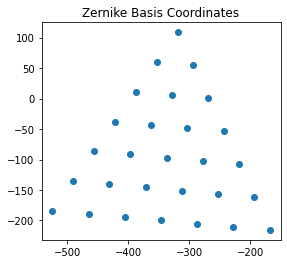

In [54]:
center = format_2vectors((500, 500))
res = (320, 320)
((i0, i1), (i2, i3)) = limits = (
    (int(center[0] - res[0]/2), int(center[0] + res[0]/2)),
    (int(center[1] - res[1]/2), int(center[1] + res[1]/2))
)

N = 28
i = np.arange(N)
nl = zernike_convert_index(i, from_index="ansi", to_index="radial")
ij = 20 * np.vstack((nl[:, 1], (3-nl[:, 0]) * np.sqrt(3))) + center
sz = convert_vector(ij, from_units="ij", to_units="zernike", hardware=fs)

plt.title("Zernike Basis Coordinates")
plt.scatter(sz[0], sz[1])
plt.gca().set_aspect("equal")

base = np.zeros((N,N))

base[2, :] = sz[0]      # Tilt x term
base[1, :] = sz[1]      # Tilt y term

In [55]:
perturbation = np.diag(np.ones(N))
print((base + 10*perturbation)[:10, :10].astype(int))

[[  10    0    0    0    0    0    0    0    0    0]
 [ 108   69   54   11    5    0  -37  -42  -48  -53]
 [-319 -353 -284 -387 -328 -269 -422 -362 -303 -243]
 [   0    0    0   10    0    0    0    0    0    0]
 [   0    0    0    0   10    0    0    0    0    0]
 [   0    0    0    0    0   10    0    0    0    0]
 [   0    0    0    0    0    0   10    0    0    0]
 [   0    0    0    0    0    0    0   10    0    0]
 [   0    0    0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0    0    0   10]]


In [61]:
hologram = CompressedSpotHologram(
    spot_vectors=base + 5*perturbation,
    basis=i,
    cameraslm=fs
)

hologram.optimize()

100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


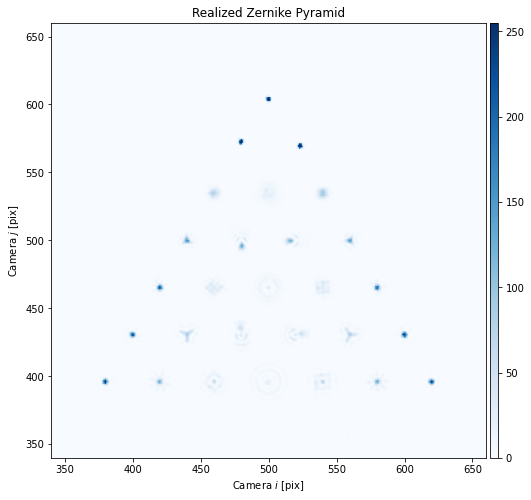

In [63]:
slm.write(hologram.get_phase())
cam.set_exposure(.02)
cam.plot(limits=limits, title="Realized Zernike Pyramid");

100%|██████████| 25/25 [01:41<00:00,  4.05s/it]


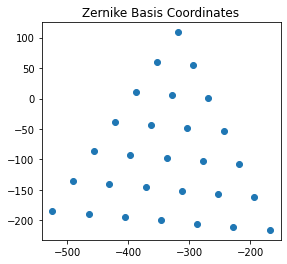

In [131]:
import tqdm.auto as tqdm

# Make the hologram
hologram = CompressedSpotHologram(
    spot_vectors=base,
    basis=i,
    cameraslm=fs
)
hologram.optimize("WGS-Leonardo", maxiter=50, verbose=False)

# Build the term osillation movie.
imgs = []
X = 5 * np.sin(np.linspace(0, 2*np.pi, 25, endpoint=False))

for x in tqdm.tqdm(X):
    # Optimize to the new position.
    hologram.spot_zernike = base + x*perturbation
    hologram.optimize("WGS-Leonardo", maxiter=10, verbose=False)

    # Project the pattern.
    slm.write(hologram.get_phase())
    imgs.append(cam.get_image()[i3:i2:-1, i0:i1])

In [132]:
from slmsuite.holography.analysis.files import write_image

write_image("ex-zernike-spots.gif", imgs, cmap="Blues", border=127, normalize=False)
write_image("ex-zernike-spots-dark.gif", imgs, cmap="turbo", border=127, normalize=False)

![light](ex-zernike-spots.gif?args) 
![dark](ex-zernike-spots-dark.gif?args)

Rather than directing power into cartesian points in space, instead think of
directing power into points in **aberration space**. This feature is be applied to
wavefront calibration in the next example, to transcend the spatial dependence of
aberration across a field of view.